In [1]:
%%capture
!pip install tensorflow pandas tqdm pyyaml h5py

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [4]:
data = dict(np.load("./data/data_single_train.npz"))
data["sequence_feat"].shape

(8550, 43, 24)

In [5]:
L = tf.keras.layers

In [6]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [7]:
def R2(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [8]:
hparams = {
    "sequence_units": [16, 32, 64],
    "dense": [16, 32],
}
hparams = {
    key: hp.HParam(key, hp.Discrete(value))
    for key, value in hparams.items()
}
metrics = [
    hp.Metric("mae", display_name="MAE"),
    hp.Metric("mse", display_name="MSE"),
    hp.Metric("r2", display_name="R2"),
]
hp.hparams_config(
    hparams=list(hparams.values()),
    metrics=metrics
)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [9]:
from itertools import product
from random import shuffle

def hparams_combinations(hparams):
    hparams_values = product(*[
        h.domain.values
        for h in hparams.values()
    ])
    hparams = [
        dict(zip(hparams.keys(), values))
        for values in hparams_values
    ]
    shuffle(hparams)
    return hparams

In [10]:
def build_model(hparams):
    model = tf.keras.Sequential([
        L.Input(shape=data["sequence_feat"].shape[1:], name="sequence_feat"),
        L.LSTM(hparams["sequence_units"]),
        L.Dense(hparams["dense"]),
        L.Dense(1)
    ])
    model.compile(optimizer="adam", loss=rmse, metrics=["mae", "mse", R2])
    return model

In [11]:
model = build_model({"sequence_units": 128, "dense": 64})

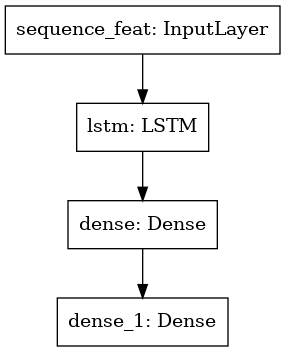

In [12]:
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file="model.png")
Image("model.png")

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               78336     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 86,657
Trainable params: 86,657
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=30)

In [15]:
index = np.arange(len(data["score"]))
train_index, test_index = train_test_split(index, test_size=0.30, random_state=42)
train_index, val_index = train_test_split(train_index, test_size=0.10, random_state=42)
X_train = [data[i.name][train_index] for i in model.inputs]
X_test = [data[i.name][test_index] for i in model.inputs]
X_val = [data[i.name][val_index] for i in model.inputs]
y_train, y_test, y_val = data["score"][train_index], data["score"][test_index],  data["score"][val_index]

In [16]:
path = "./board"
for i, h in enumerate(tqdm(hparams_combinations(hparams))):
    logs = os.path.join(path, f"run-{i}")
    os.makedirs(logs)
    with tf.summary.create_file_writer(logs).as_default():
        hp.hparams(h)
        model = build_model(h)
        model.fit(
            X_train,
            y_train,
            epochs=int(1e3),
            batch_size=32,
            shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0
        )
        loss, mae, mse, r2 = model.evaluate(X_test, y_test, verbose=0)
        tf.summary.scalar("loss", loss, step=i)
        tf.summary.scalar("mae", mae, step=i)
        tf.summary.scalar("mse", mse, step=i)
        tf.summary.scalar("r2", r2, step=i)

100%|██████████| 6/6 [15:17<00:00, 152.95s/it]


In [19]:
parameters = {"sequence_units": 128, "dense": 64}

In [21]:
model = build_model(parameters)
X_train = [data[i.name] for i in model.inputs]
y_train = data["score"]
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/500
241/241 [==============================] - 3s 7ms/step - loss: 0.4542 - mae: 0.3759 - mse: 0.2546 - R2: -0.6405 - val_loss: 0.2933 - val_mae: 0.2367 - val_mse: 0.0868 - val_R2: 0.4262
Epoch 2/500
241/241 [==============================] - 1s 6ms/step - loss: 0.2697 - mae: 0.2080 - mse: 0.0750 - R2: 0.5004 - val_loss: 0.2736 - val_mae: 0.2203 - val_mse: 0.0759 - val_R2: 0.4977
Epoch 3/500
241/241 [==============================] - 1s 6ms/step - loss: 0.2531 - mae: 0.1871 - mse: 0.0664 - R2: 0.5699 - val_loss: 0.2543 - val_mae: 0.1909 - val_mse: 0.0668 - val_R2: 0.5679
Epoch 4/500
241/241 [==============================] - 1s 6ms/step - loss: 0.2474 - mae: 0.1819 - mse: 0.0632 - R2: 0.5910 - val_loss: 0.2491 - val_mae: 0.1796 - val_mse: 0.0647 - val_R2: 0.5814
Epoch 5/500
241/241 [==============================] - 1s 6ms/step - loss: 0.2381 - mae: 0.1763 - mse: 0.0589 - R2: 0.6167 - val_loss: 0.2355 - val_mae: 0.1777 - val_mse: 0.0572 - val_R2: 0.6259
Epoch 6/500
241/241 [===

In [22]:
model.save("model_single.h5")

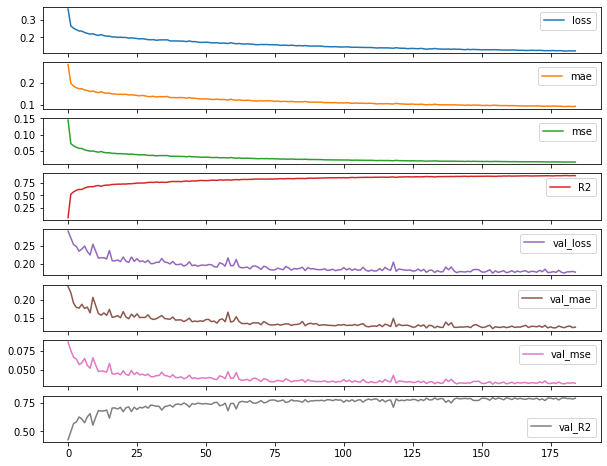

In [23]:
_ = pd.DataFrame(history.history).plot(subplots=True, figsize=(10, 8))

In [24]:
test = dict(np.load("./data/data_single_test.npz"))
X_test = [test[i.name] for i in model.inputs]
y_test = test["score"]
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

,target,predicted
target,1.000000,0.900618
predicted,0.900618,1.000000


In [25]:
evaluate.to_csv("evaluate_single.csv")

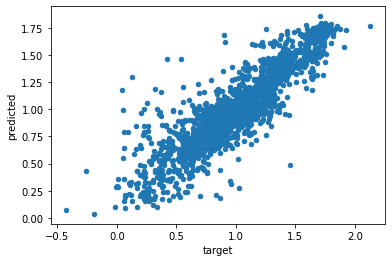

In [26]:
_ = evaluate.plot.scatter("target", "predicted")

In [27]:
data = dict(np.load("./data/data_multi_train.npz"))
data["sequence_feat"].shape

(29156, 43, 24)

In [29]:
model = build_model(parameters)
X_train = [data[i.name] for i in model.inputs]
y_train = data["score"]
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/500
410/410 [==============================] - 3s 6ms/step - loss: 0.4705 - mae: 0.3549 - mse: 0.2241 - R2: 0.0196 - val_loss: 0.3902 - val_mae: 0.2935 - val_mse: 0.1545 - val_R2: 0.0858
Epoch 2/500
410/410 [==============================] - 2s 6ms/step - loss: 0.4358 - mae: 0.3346 - mse: 0.1920 - R2: 0.1236 - val_loss: 0.3568 - val_mae: 0.2834 - val_mse: 0.1284 - val_R2: 0.2224
Epoch 3/500
410/410 [==============================] - 2s 6ms/step - loss: 0.4206 - mae: 0.3262 - mse: 0.1790 - R2: 0.1901 - val_loss: 0.3768 - val_mae: 0.2973 - val_mse: 0.1431 - val_R2: 0.1250
Epoch 4/500
410/410 [==============================] - 2s 6ms/step - loss: 0.4198 - mae: 0.3263 - mse: 0.1784 - R2: 0.1916 - val_loss: 0.3575 - val_mae: 0.2742 - val_mse: 0.1294 - val_R2: 0.2274
Epoch 5/500
410/410 [==============================] - 2s 6ms/step - loss: 0.4174 - mae: 0.3246 - mse: 0.1761 - R2: 0.2165 - val_loss: 0.3925 - val_mae: 0.2989 - val_mse: 0.1563 - val_R2: 0.0711
Epoch 6/500
410/410 [====

In [30]:
model.save("model_multi.h5")

In [31]:
test = dict(np.load("./data/data_multi_test.npz"))
X_test = [test[i.name] for i in model.inputs]
y_test = test["score"]
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

,target,predicted
target,1.000,0.539
predicted,0.539,1.000


In [32]:
evaluate.to_csv("evaluate_multi.csv")

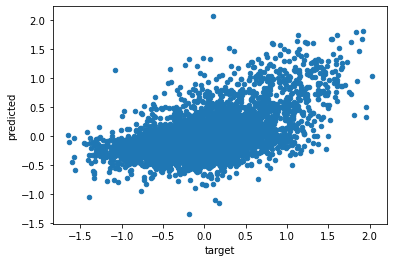

In [33]:
_ = evaluate.plot.scatter("target", "predicted")